## conv autoencoder for mnist denoising

In [1]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


## prepare data

In [2]:
dataset_dir = os.path.join(os.path.expanduser('~'), 'bitbucket/test_data/mnist')
dataset = read_data_sets(dataset_dir)
train_images, train_labels = dataset.train.images, dataset.train.labels
test_images, test_labels = dataset.test.images, dataset.test.labels
train_images = np.asarray(train_images, dtype='float32').reshape((-1, 28, 28, 1))
test_images = np.asarray(test_images, dtype='float32').reshape((-1, 28, 28, 1))
print(train_images.shape, test_images.shape)
print(np.max(test_images), np.min(test_images))

Extracting /home/huizhu/bitbucket/test_data/mnist/train-images-idx3-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/t10k-labels-idx1-ubyte.gz
((55000, 28, 28, 1), (10000, 28, 28, 1))
(1.0, 0.0)


## add noise

In [12]:
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape).astype(np.float32) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape).astype(np.float32)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

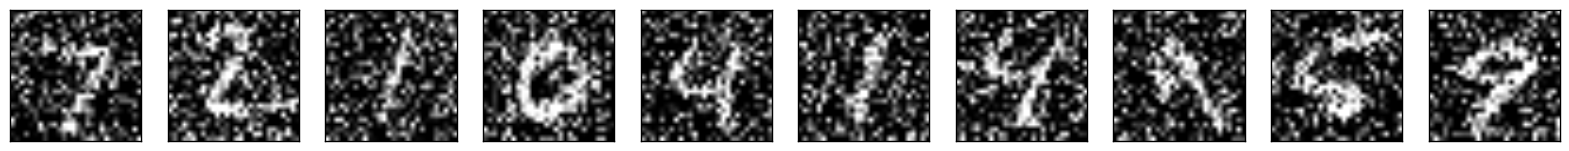

In [13]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(test_images_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## build conv autoencoder

In [14]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
log_dir = os.path.join(dataset_dir, 'conv_autoencoder')
config_file = os.path.join(log_dir, 'config.joblib')
hdf5_file = os.path.join(log_dir, 'weights.hdf5')

joblib.dump(autoencoder.get_config(), config_file)
checkpoint = ModelCheckpoint(hdf5_file, save_best_only=True, period=2)
tensorboard = TensorBoard(log_dir, write_images=False, histogram_freq=1)
autoencoder.fit(train_images_noisy[:1000], train_images[:1000],
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(test_images_noisy, test_images),
                callbacks=[tensorboard, checkpoint])
print(autoencoder.summary())
print(autoencoder.input_shape, autoencoder.output_shape)
print(train_images_noisy.dtype, train_images.dtype)

Train on 1000 samples, validate on 10000 samples
INFO:tensorflow:Summary name conv2d_6/kernel:0 is illegal; using conv2d_6/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_6/bias:0 is illegal; using conv2d_6/bias_0 instead.
INFO:tensorflow:Summary name conv2d_7/kernel:0 is illegal; using conv2d_7/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_7/bias:0 is illegal; using conv2d_7/bias_0 instead.
INFO:tensorflow:Summary name conv2d_8/kernel:0 is illegal; using conv2d_8/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_8/bias:0 is illegal; using conv2d_8/bias_0 instead.
INFO:tensorflow:Summary name conv2d_9/kernel:0 is illegal; using conv2d_9/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_9/bias:0 is illegal; using conv2d_9/bias_0 instead.
INFO:tensorflow:Summary name conv2d_10/kernel:0 is illegal; using conv2d_10/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_10/bias:0 is illegal; using conv2d_10/bias_0 instead.
Epoch 1/100
 992/1000 [========================